In [ ]:
#Imports
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns
import time
from datetime import date, timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder,StandardScaler  
from tqdm import tqdm
from scipy.stats import poisson
import scipy.stats as stats
%matplotlib inline

from google.oauth2.service_account import Credentials
import google_auth_httplib2
import pygsheets
import df2gspread as d2g
import googleapiclient
from googleapiclient  import discovery
from httplib2 import Http
from oauth2client import file, client, tools
from gspread_formatting.dataframe import format_with_dataframe, BasicFormatter
from gspread_formatting import Color
import logging

from oauth2client.service_account import ServiceAccountCredentials
from google.oauth2 import service_account
import gslides
from gslides import (Frame,Presentation,Spreadsheet,Table,Series,Chart)

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

import sqlalchemy as db
from sqlalchemy import create_engine
import mysql.connector
import psycopg2

In [ ]:
# GBQ logging
import logging
logger = logging.getLogger('pandas_gbq')
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler())

In [34]:
# GBQ service account connection
credentials=Credentials.from_service_account_file('C:/Users/mncedisi.mncwabe/Documents/Connect to BQ/tal-production-data-4390ad039b75.json')

In [35]:
# GBQ service account connection
cre_marketing=Credentials.from_service_account_file('C:/Users/mncedisi.mncwabe/Downloads/tal-production-marketing-e93d689c8a94.json')

In [29]:
start_time = time.time()

query_once_off = '''

SELECT * FROM (
SELECT z.customer_id,SUM(z.Recency) AS Recency,SUM(z.Frequency) AS Frequency,SUM(z.Monetary) AS Monetary,
SUM(z.Duration) AS Duration,SUM(z.Units) AS Units
FROM
(
SELECT y.customer_id, y.FY,#y.Division,
CASE WHEN y.FY="FY20" THEN DATE_DIFF(CAST("2020-04-01"AS DATE),MAX(DATE(y.Auth_Date)),DAY) 
     WHEN y.FY="FY21" THEN DATE_DIFF(CAST("2021-04-01"AS DATE),MAX(DATE(y.Auth_Date)),DAY)
     ELSE DATE_DIFF(CAST("2022-06-18"AS DATE),MAX(DATE(y.Auth_Date)),DAY)
END AS Recency, SUM(y.Frequency) AS Frequency, SUM(y.Monetary) AS Monetary,
CASE 
     WHEN (DATE_DIFF(MAX(DATE(y.Auth_Date)),MIN(DATE(y.Auth_Date)),DAY))=0 
     THEN   (IF(y.FY="FY20",DATE_DIFF(CAST("2020-04-01"AS DATE),MAX(DATE(y.Auth_Date)),DAY), 
             IF(y.FY="FY21", DATE_DIFF(CAST("2021-04-01"AS DATE),MAX(DATE(y.Auth_Date)),DAY)
            ,DATE_DIFF(CAST("2022-06-18"AS DATE),MAX(DATE(y.Auth_Date)),DAY))))
     WHEN y.FY="FY20" THEN DATE_DIFF(MAX(DATE(y.Auth_Date)),MIN(DATE(y.Auth_Date)),DAY)
     WHEN y.FY="FY21" THEN DATE_DIFF(MAX(DATE(y.Auth_Date)),MIN(DATE(y.Auth_Date)),DAY)
ELSE DATE_DIFF(MAX(DATE(y.Auth_Date)),MIN(DATE(y.Auth_Date)),DAY)
END AS Duration,
SUM(y.Units) AS Units
FROM 
(
SELECT
     customer_id,
     x.Auth_Date,
     CASE WHEN DATE(x.Auth_Date) >= '2019-04-01' AND DATE(x.Auth_Date) < '2020-04-01' THEN "FY20"
          WHEN DATE(x.Auth_Date) >= '2020-04-01' AND DATE(x.Auth_Date) < '2021-04-01' THEN "FY21"
          WHEN DATE(x.Auth_Date) >= '2021-04-01' AND DATE(x.Auth_Date) < '2022-04-01' THEN "FY22"
          WHEN DATE(x.Auth_Date) >= '2022-04-01' AND DATE(x.Auth_Date) < '2023-04-01' THEN "FY23"
      END AS FY,
      #FORMAT_DATE("%Y-%m",x.Auth_Date) AS YearMonth,
      #x.Division,
      /*x.Department,
       x.Level1,*/
      DATE_DIFF(CAST("2022-06-18" AS DATE),MAX(DATE(x.Auth_Date)),DAY) AS Recency,
      COUNT(DISTINCT x.order_id) AS Frequency,
      ROUND(SUM(x.order_item_sales),2) AS Monetary,
      IF((DATE_DIFF(MAX(DATE(x.Auth_Date)),MIN(DATE(x.Auth_Date)),DAY))=0,
      DATE_DIFF(CAST("2022-06-18" AS DATE),MAX(DATE(x.Auth_Date)),DAY),(DATE_DIFF(MAX(DATE(x.Auth_Date)),MIN(DATE(x.Auth_Date)),DAY))) AS Duration,
      SUM(x.Units) AS Units,

FROM (      

SELECT DISTINCT o.customer_id,
        #bh.bh_division AS Division, 
        /*bh.bh_reporting_department AS Department,
        bh.bh_level_1 AS Level1,*/
        DATE(o.order_authed_timestamp) AS Auth_Date,
        o.order_id,
        oi.order_item_sales,
        oi.order_item_quantity AS Units
    FROM `tal-production-data-bi.tal_dm_order.orders_2020_2030` o,
        UNNEST(o.order_items) oi
    INNER JOIN `tal-production-data-bi.tal_dm_product.business_hierarchy` bh
        ON bh.product_id = oi.product_id
    WHERE   
        DATE(o.order_placed_timestamp) >= "2022-01-01" AND DATE(o.order_placed_timestamp) < "2022-06-18" 
        AND DATE(o.order_authed_timestamp) >= "2022-01-01" AND DATE(o.order_authed_timestamp) < "2022-06-18" 
        AND o.order_authorisation_status IN ('Auth')
        AND o.is_not_return_cancel_in_full IS TRUE
        AND is_test_customer = false
        AND oi.order_item_status LIKE 'Shipped') x
    #where customer_id=2005339
    #AND Division = "Home"
    GROUP BY 1,2,3

    ORDER BY Auth_Date ASC) y
    WHERE y.FY IS NOT NULL #AND customer_id=5858791
    GROUP BY 1,2) z
    GROUP BY 1) p
     WHERE Frequency=1
  

'''
df_once_off = pd.read_gbq(query_once_off, project_id='gcp-takealot', dialect='standard', credentials=credentials,progress_bar_type='tqdm_notebook')

print("--- %s seconds ---" % (time.time() - start_time))

Requesting query... 
2022-06-28 21:26:58,576 : DEBUG : Requesting query... 
Query running...
2022-06-28 21:27:02,304 : DEBUG : Query running...
Job ID: c505f13f-05ab-4404-979f-99c043c6d44c
2022-06-28 21:27:02,304 : DEBUG : Job ID: c505f13f-05ab-4404-979f-99c043c6d44c
  Elapsed 13.83 s. Waiting...
2022-06-28 21:27:12,409 : INFO :   Elapsed 13.83 s. Waiting...
Query done.
Processed: 1.7 GB Billed: 1.7 GB
2022-06-28 21:27:19,099 : DEBUG : Query done.
Processed: 1.7 GB Billed: 1.7 GB
Standard price: $0.01 USD

2022-06-28 21:27:19,099 : DEBUG : Standard price: $0.01 USD



Downloading:   0%|          | 0/1044325 [00:00<?, ?rows/s]

ModuleNotFoundError: No module named 'pandas.core.arrays._arrow_utils'

In [30]:
start_time = time.time()

query_repeat = '''


SELECT *,
CASE WHEN Frequency>1 THEN 1
    ELSE 0
  END AS Repater,
 FROM (
SELECT z.customer_id,SUM(z.Recency) AS Recency,SUM(z.Frequency) AS Frequency,SUM(z.Monetary) AS Monetary,
SUM(z.Duration) AS Duration,SUM(z.Units) AS Units
FROM
(
SELECT y.customer_id, y.FY,#y.Division,
CASE WHEN y.FY="FY20" THEN DATE_DIFF(CAST("2020-04-01"AS DATE),MAX(DATE(y.Auth_Date)),DAY) 
     WHEN y.FY="FY21" THEN DATE_DIFF(CAST("2021-04-01"AS DATE),MAX(DATE(y.Auth_Date)),DAY)
     ELSE DATE_DIFF(CAST("2022-06-18"AS DATE),MAX(DATE(y.Auth_Date)),DAY)
END AS Recency, SUM(y.Frequency) AS Frequency, SUM(y.Monetary) AS Monetary,
CASE 
     WHEN (DATE_DIFF(MAX(DATE(y.Auth_Date)),MIN(DATE(y.Auth_Date)),DAY))=0 
     THEN   (IF(y.FY="FY20",DATE_DIFF(CAST("2020-04-01"AS DATE),MAX(DATE(y.Auth_Date)),DAY), 
             IF(y.FY="FY21", DATE_DIFF(CAST("2021-04-01"AS DATE),MAX(DATE(y.Auth_Date)),DAY)
            ,DATE_DIFF(CAST("2022-06-18"AS DATE),MAX(DATE(y.Auth_Date)),DAY))))
     WHEN y.FY="FY20" THEN DATE_DIFF(MAX(DATE(y.Auth_Date)),MIN(DATE(y.Auth_Date)),DAY)
     WHEN y.FY="FY21" THEN DATE_DIFF(MAX(DATE(y.Auth_Date)),MIN(DATE(y.Auth_Date)),DAY)
ELSE DATE_DIFF(MAX(DATE(y.Auth_Date)),MIN(DATE(y.Auth_Date)),DAY)
END AS Duration,
SUM(y.Units) AS Units
FROM 
(
SELECT
     customer_id,
     x.Auth_Date,
     CASE WHEN DATE(x.Auth_Date) >= '2019-04-01' AND DATE(x.Auth_Date) < '2020-04-01' THEN "FY20"
          WHEN DATE(x.Auth_Date) >= '2020-04-01' AND DATE(x.Auth_Date) < '2021-04-01' THEN "FY21"
          WHEN DATE(x.Auth_Date) >= '2021-04-01' AND DATE(x.Auth_Date) < '2022-04-01' THEN "FY22"
          WHEN DATE(x.Auth_Date) >= '2022-04-01' AND DATE(x.Auth_Date) < '2023-04-01' THEN "FY23"
      END AS FY,
      #FORMAT_DATE("%Y-%m",x.Auth_Date) AS YearMonth,
      #x.Division,
      /*x.Department,
       x.Level1,*/
      DATE_DIFF(CAST("2022-06-18" AS DATE),MAX(DATE(x.Auth_Date)),DAY) AS Recency,
      COUNT(DISTINCT x.order_id) AS Frequency,
      ROUND(SUM(x.order_item_sales),2) AS Monetary,
      IF((DATE_DIFF(MAX(DATE(x.Auth_Date)),MIN(DATE(x.Auth_Date)),DAY))=0,
      DATE_DIFF(CAST("2022-06-18" AS DATE),MAX(DATE(x.Auth_Date)),DAY),(DATE_DIFF(MAX(DATE(x.Auth_Date)),MIN(DATE(x.Auth_Date)),DAY))) AS Duration,
      SUM(x.Units) AS Units,

FROM (      

SELECT DISTINCT o.customer_id,
        #bh.bh_division AS Division, 
        /*bh.bh_reporting_department AS Department,
        bh.bh_level_1 AS Level1,*/
        DATE(o.order_authed_timestamp) AS Auth_Date,
        o.order_id,
        oi.order_item_sales,
        oi.order_item_quantity AS Units
    FROM `tal-production-data-bi.tal_dm_order.orders_2020_2030` o,
        UNNEST(o.order_items) oi
    INNER JOIN `tal-production-data-bi.tal_dm_product.business_hierarchy` bh
        ON bh.product_id = oi.product_id
    WHERE   
        DATE(o.order_placed_timestamp) >= "2022-01-01" AND DATE(o.order_placed_timestamp) < "2022-06-18" 
        AND DATE(o.order_authed_timestamp) >= "2022-01-01" AND DATE(o.order_authed_timestamp) < "2022-06-18" 
        AND o.order_authorisation_status IN ('Auth')
        AND o.is_not_return_cancel_in_full IS TRUE
        AND is_test_customer = false
        AND oi.order_item_status LIKE 'Shipped') x
    #where customer_id=2005339
    #AND Division = "Home"
    GROUP BY 1,2,3

    ORDER BY Auth_Date ASC) y
    WHERE y.FY IS NOT NULL #AND customer_id=5858791
    GROUP BY 1,2) z
    GROUP BY 1) p
  
'''
df_repeat = pd.read_gbq(query_repeat, project_id='gcp-takealot', dialect='standard', credentials=credentials,progress_bar_type='tqdm_notebook')

print("--- %s seconds ---" % (time.time() - start_time))

Requesting query... 
2022-06-28 21:28:15,679 : DEBUG : Requesting query... 
Query running...
2022-06-28 21:28:19,449 : DEBUG : Query running...
Job ID: 574cdae4-b60f-44c7-a617-4e5fd6a10c0e
2022-06-28 21:28:19,450 : DEBUG : Job ID: 574cdae4-b60f-44c7-a617-4e5fd6a10c0e
  Elapsed 13.86 s. Waiting...
2022-06-28 21:28:29,534 : INFO :   Elapsed 13.86 s. Waiting...
  Elapsed 23.99 s. Waiting...
2022-06-28 21:28:39,668 : INFO :   Elapsed 23.99 s. Waiting...
Query done.
Processed: 1.7 GB Billed: 1.7 GB
2022-06-28 21:28:40,937 : DEBUG : Query done.
Processed: 1.7 GB Billed: 1.7 GB
Standard price: $0.01 USD

2022-06-28 21:28:40,937 : DEBUG : Standard price: $0.01 USD



Downloading:   0%|          | 0/2291871 [00:00<?, ?rows/s]

ModuleNotFoundError: No module named 'pandas.core.arrays._arrow_utils'

In [37]:
df_pred_dep = pd.read_pickle('df_no_lvl1_file.pkl')

In [33]:
df_once_off['Monetary'] = df_once_off['Monetary'].astype(float)
df_repeat['Monetary'] = df_repeat['Monetary'].astype(float)

NameError: name 'df_once_off' is not defined

In [39]:
df_pred_dep['Recency'] = np.where((df_pred_dep['Recency']>df_pred_dep['Duration']),df_pred_dep['Duration'],df_pred_dep['Recency'])
df_pred_dep['Monetary'] = round(np.floor(pd.to_numeric(df_pred_dep['Monetary'], errors='coerce')).astype('float64'),0)
df_pred_dep['Recency'] = round(np.floor(pd.to_numeric(df_pred_dep['Recency'], errors='coerce')).astype('float64'),0)
df_pred_dep['Frequency'] = round(np.floor(pd.to_numeric(df_pred_dep['Frequency'], errors='coerce')).astype('float64'),0)
df_pred_dep['Duration'] = round(np.floor(pd.to_numeric(df_pred_dep['Duration'], errors='coerce')).astype('float64'),0)

In [40]:
df_pred_dep = df_pred_dep.head(600000)

In [41]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score,roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score, f1_score
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import confusion_matrix, precision_score, plot_confusion_matrix,classification_report
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import precision_recall_curve
from xgboost import XGBClassifier

In [42]:
import lifetimes
from lifetimes import BetaGeoFitter
from lifetimes.fitters.modified_beta_geo_fitter import ModifiedBetaGeoFitter
from lifetimes import ParetoNBDFitter
from lifetimes.fitters.pareto_nbd_fitter import ParetoNBDFitter
from lifetimes.plotting import plot_frequency_recency_matrix
from lifetimes.plotting import plot_probability_alive_matrix
from lifetimes.plotting import plot_period_transactions
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_probability_alive_matrix
from lifetimes.plotting import plot_expected_repeat_purchases
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases

In [47]:
start_time = time.time()

par_dep = ParetoNBDFitter(penalizer_coef=0.01) 
par_dep.fit(df_pred_dep['Frequency'],df_pred_dep['Recency'],df_pred_dep['Duration'])
print(par_dep) 

print("--- %s seconds ---" % (time.time() - start_time))


KeyboardInterrupt



In [46]:
par = ParetoNBDFitter()
par.load_model('par.pkl')

AttributeError: Can't get attribute 'new_block' on <module 'pandas.core.internals.blocks' from 'C:\\Users\\mncedisi.mncwabe\\AppData\\Roaming\\Python\\Python39\\site-packages\\pandas\\core\\internals\\blocks.py'>

In [22]:
# Probability to make an order in the next 60 days
t = 60
n = 1
df_pred_dep['prob_to_buy'] = par_dep.conditional_probability_of_n_purchases_up_to_time(n,t, df_pred_dep['Frequency'].values, df_pred_dep['Recency'].values, df_pred_dep['Duration'].values)
df_pred_dep.sort_values(by='prob_to_buy', ascending=False).head()

,customer_id,Recency,Frequency,Monetary,Duration,Units,prob_to_buy
190578,10004112,3.0,1.0,433.0,3.0,1,0.340402
39283,5713940,3.0,1.0,700.0,3.0,1,0.340402
39169,5586146,3.0,1.0,415.0,3.0,1,0.340402
171380,1566933,3.0,1.0,471.0,3.0,4,0.340402
171371,3447326,3.0,1.0,1692.0,3.0,4,0.340402


In [ ]:
df_1p = df_pred_dep.groupby(['Division','Cust_Seq_Cat']).agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'Duration': 'mean',
    'Units',:
    'prob_to_buy':'mean',
    'prob_active':'mean',
    'predicted_orders':'sum',
    'predicted_gmv':'sum',
    'customer_id':'nunique'
}).reset_index() 
df_pred_dep

In [48]:
df_repeat = pd.read_csv('C:/Users/mncedisi.mncwabe/Downloads/df_repeater.csv')

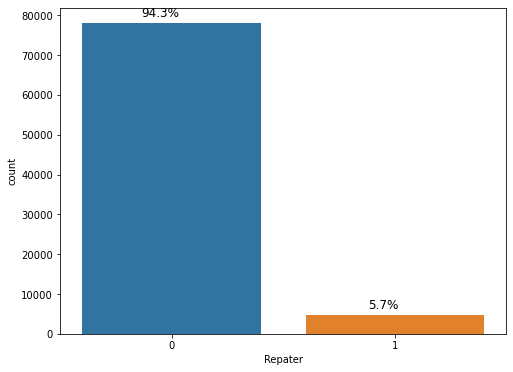

In [49]:
def target(plot, feature):
    total = len(feature)
    for p in plot.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        plot.annotate(percentage, (x, y), size = 12,ha = 'center', va = 'center', xytext = (0, 10), 
                                                                        textcoords = 'offset points')
    plt.show()

plt.figure(figsize=(8, 6))
plot = sns.countplot(df_repeat['Repater'])


target(plot,df_repeat.Repater)

In [50]:
X = df_repeat.drop(['Repater','Duration','Frequency','customer_id'],axis=1)
y = df_repeat['Repater']

y=y.astype('int')

In [51]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=100)

In [52]:
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(57925, 3) (57925,)
(24825, 3) (24825,)


In [265]:
rs.best_params_

{'min_samples_split': 5,
 'max_leaf_nodes': 48,
 'max_features': 0.7999999999999999,
 'max_depth': 16,
 'criterion': 'entropy'}

In [65]:
# Random Forest
dt = DecisionTreeClassifier(max_depth=16,criterion="entropy"
                            ,min_samples_split=5,max_leaf_nodes=48,max_features=0.79999)
dt.fit(X_train,y_train)
print('accurary(%):',dt.score(X_test,y_test)*100)

accurary(%): 99.85095669687814


In [54]:
y_pred_train = dt.predict(X_train)

y_pred_test = dt.predict(X_test)


print("Training accuracy: ", accuracy_score(y_train, y_pred_train))
print("Testing accuracy: ", accuracy_score(y_test, y_pred_test))

Training accuracy:  0.9994820889080708
Testing accuracy:  0.998147029204431


Precision Score: 98.119777


<Figure size 720x432 with 0 Axes>

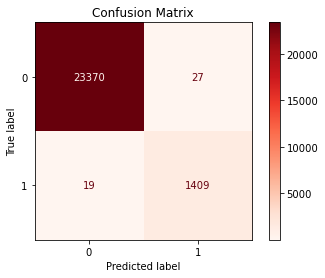

In [55]:
pd.set_option('display.float_format', lambda s: '%.0f' % s)
y_pred = dt.predict(X_test)

plt.figure(figsize=(10,6))

print("Precision Score: %f" % (precision_score(y_test, y_pred) * 100))
plot_confusion_matrix(dt, X_test, y_test, cmap=plt.cm.Reds)
plt.title("Confusion Matrix")
plt.show()

In [56]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     23397
           1       0.98      0.99      0.98      1428

    accuracy                           1.00     24825
   macro avg       0.99      0.99      0.99     24825
weighted avg       1.00      1.00      1.00     24825



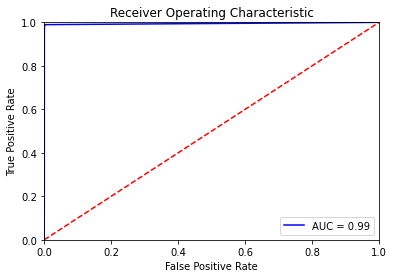

In [57]:
# ROC CURVE 
probs = dt.predict_proba(X_test)  
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

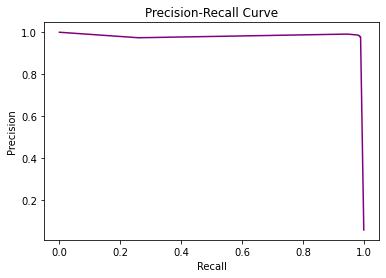

In [58]:
y_score = dt.predict_proba(X_test)[:, 1]

#calculate precision and recall
precision, recall, thresholds = precision_recall_curve(y_test, y_score)

#create precision recall curve
fig, ax = plt.subplots()
ax.plot(recall, precision, color='purple')

#add axis labels to plot
ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

#display plot
plt.show()

In [68]:
plt.figure(figsize=(10,6))

feat_importances = pd.Series(dt.feature_importances_, index=X_train.columns)
feat_importances.nsmallest(40).plot(kind='barh')
importances = dt.feature_importances_
indices = np.argsort(importances)


plt.xlabel('Importance')
plt.ylabel('Features')
plt.title("Features that are most important")
plt.show()

ImportError: matplotlib is required for plotting when the default backend "matplotlib" is selected.

<Figure size 720x432 with 0 Axes>

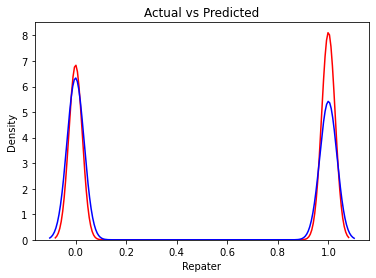

In [166]:
ax = sns.distplot(y, hist=False, color="r", label="Actual Value")
sns.distplot(y_pred, hist=False, color="b", label="Fitted Values" , ax=ax)
plt.title('Actual vs Predicted')
plt.show()
plt.close()

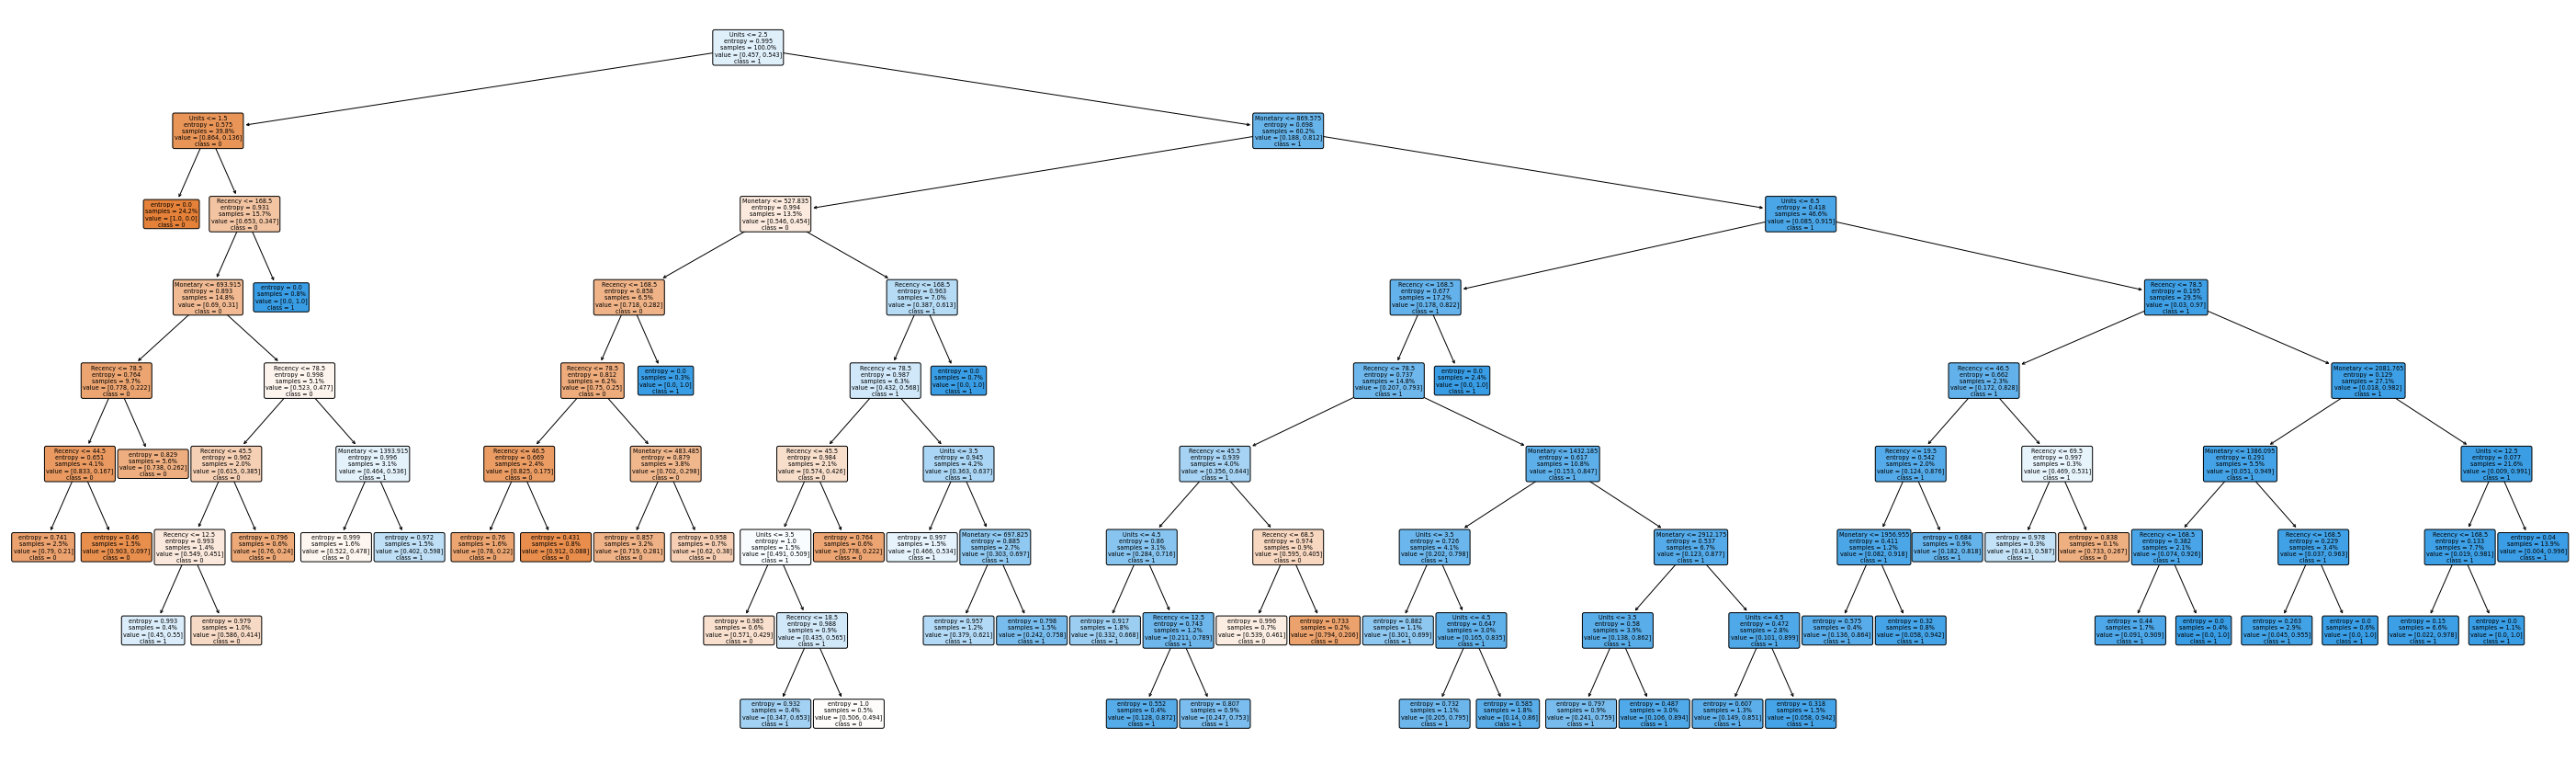

In [279]:
import pydot
from sklearn import tree

fig = plt.figure(figsize=(50,15))
tree.plot_tree(dt, 
          feature_names = ['Recency','Monetary','Units'], 
          class_names = ['0','1'], 
          filled = True, 
          rounded = True,
          proportion=True,
          label='all');

In [280]:
df_repeat['PD'] = dt.predict_proba(df_repeat[X_train.columns])[:,1]
df_repeat.head()

,customer_id,Recency,Frequency,Monetary,Duration,Units,Repater,PD
0,2285431,85,14,50262,142,41,1,1
1,2679827,126,12,18188,67,27,1,1
2,3568498,136,13,23981,59,62,1,1
3,7989652,114,12,31487,98,39,1,1
4,7605576,99,12,21389,93,35,1,1


In [226]:
df_repeat = df_repeat.drop('PD',axis=1)

In [281]:
df_repeat['PD'].describe()

count   2280469
mean          1
std           0
min           0
25%           0
50%           1
75%           1
max           1
Name: PD, dtype: float64

In [22]:
df_dep = pd.read_csv('C:/Users/mncedisi.mncwabe/Downloads/2additional.csv')

In [23]:
def prob_cat(df):
    if (df['prob_to_buy'] < 0.1) :
        return '<10%'
    elif ((df['prob_to_buy'] >= 0.1) and (df['prob_to_buy'] < 0.2)):
        return '10-20%'
    elif ((df['prob_to_buy'] >= 0.2) and (df['prob_to_buy'] < 0.3)):
        return '20-30%'
    elif ((df['prob_to_buy'] >= 0.3) and (df['prob_to_buy'] < 0.4)):
        return '30-40%'
    elif ((df['prob_to_buy'] >= 0.4) and (df['prob_to_buy'] < 0.5)):
        return '40-50%'   
    elif ((df['prob_to_buy'] >= 0.5) and (df['prob_to_buy'] < 0.6)):
        return '50-60%'
    elif ((df['prob_to_buy'] >= 0.6) and (df['prob_to_buy'] < 0.7)):
        return '60-70%'
    elif ((df['prob_to_buy'] >= 0.7) and (df['prob_to_buy'] < 0.8)):
        return '70-80%'
    elif ((df['prob_to_buy'] >= 0.8) and (df['prob_to_buy'] < 0.9)):
        return '80-90%'    
    else:
        return '>90%'
    

df_dep['prob_cat2'] = df_dep.apply(prob_cat, axis=1)
df_dep.head()

,Division,Department,Cust_Seq_Cat,prob_cat,count,Recency,Frequency,Monetary,Duration,prob_to_buy,predicted_orders,predicted_gmv,AOV,prob_cat2
0,Consumables,Baby,11-->13 Purchaser,50-60%,104,68.0,11.0,5177.9,281.9,0.6039,96.57,"960,174.36","9,942.47",60-70%
1,Consumables,Baby,12-->14 Purchaser,50-60%,77,65.0,12.0,5627.6,288.5,0.6140,47.94,"772,856.17","16,120.31",60-70%
2,Consumables,Baby,13-->15 Purchaser,40-50%,"14,650",62.3,13.0,6114.4,292.9,0.5390,41.72,"627,425.18","15,037.87",50-60%
3,Consumables,Baby,14-->16 Purchaser,40-50%,"10,750",59.9,14.0,6747.9,297.2,0.4801,20.21,"509,254.84","25,201.90",40-50%
4,Consumables,Baby,15-->17 Purchaser,30-40%,"8,075",58.8,15.0,7012.3,303.3,0.4379,16.45,"395,212.69","24,022.17",40-50%


In [24]:
df_dep.to_csv('df_dep.csv')